In [1]:
import json
import uproot
import uproot_methods
import awkward
import numpy as np
from functools import partial
%matplotlib nbagg

import cloudpickle, lz4.frame as lz4f

import fnal_column_analysis_tools.processor as processor
import fnal_column_analysis_tools.hist as hist
from fnal_column_analysis_tools.hist import plot
import matplotlib.pyplot as plt

In [2]:
plt.rcParams.update({
    'font.size': 14,
    'axes.titlesize': 14,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'xtick.direction': 'in',
    'xtick.top': True,
    'ytick.labelsize': 12,
    'ytick.direction': 'in',
    'ytick.right': True,
    'legend.fontsize': 12,
})

In [13]:
with open('files_prev.json') as fin:
    samples = json.load(fin)

# samples['GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8'] = samples['GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8'][:2]
del samples['GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8']
redir = 'root://cmsxrootd.fnal.gov/'
samples = {k: [redir+f for f in v] for k, v in samples.items()}
print("\n".join(samples.keys()))

GluGluHToBB_M125_13TeV_powheg_pythia8
GluGluHToBB_M125_13TeV_amcatnloFXFX_pythia8
GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8
VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix


In [14]:
samples['MG5TopMassEffects'] = ['/uscms_data/d3/ncsmith/dazsle/genstuff/mg5masseffects/nanogen/output.root']

In [7]:
frwt = uproot.open('ggh_ptH_n3lo.root')
num = frwt['h_nnnlo_ptH']
den = frwt['h_lo_ptH']
from fnal_column_analysis_tools import lookup_tools
ptreweight = lookup_tools.dense_lookup.dense_lookup(num.values/den.values, num.edges)

<IPython.core.display.Javascript object>


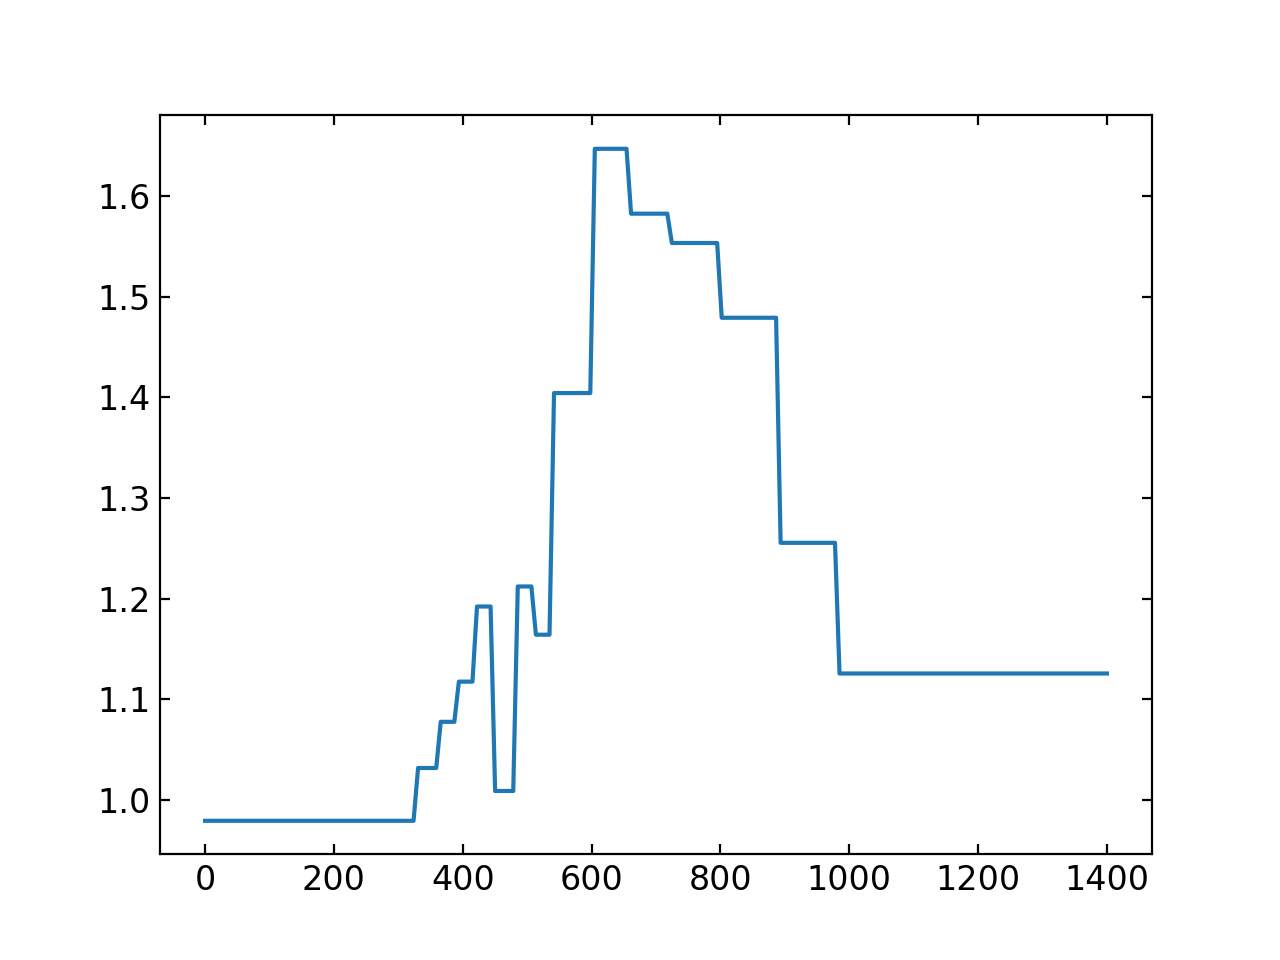

In [8]:
x = np.linspace(0,1400,200)
plt.plot(x, ptreweight(x))

In [10]:
class HiggsGenComparison(processor.ProcessorABC):        
    _gen_statusFlags = {
        0: 'isPrompt',
        1: 'isDecayedLeptonHadron',
        2: 'isTauDecayProduct',
        3: 'isPromptTauDecayProduct',
        4: 'isDirectTauDecayProduct',
        5: 'isDirectPromptTauDecayProduct',
        6: 'isDirectHadronDecayProduct',
        7: 'isHardProcess',
        8: 'fromHardProcess',
        9: 'isHardProcessTauDecayProduct',
        10: 'isDirectHardProcessTauDecayProduct',
        11: 'fromHardProcessBeforeFSR',
        12: 'isFirstCopy',
        13: 'isLastCopy',
        14: 'isLastCopyBeforeFSR'
    }
    
    def __init__(self):
        dataset_axis = hist.Cat("dataset", "Primary dataset")
        pt_axis = hist.Bin("pt", r"$p_{T,h}$ [GeV]", 120, 0., 1200.)
        detajj_axis = hist.Bin("detajj", r"$\Delta\eta_{jj}$", 40, 0, 8)
        mjj_axis = hist.Bin("mjj", r"$m_{jj}$", 40, 0, 1000)
        widx_axis = hist.Bin("widx", "Weight index", 9, 0, 9)
        
        self._accumulator = processor.dict_accumulator({
            'hpt': hist.Hist("Counts", dataset_axis, pt_axis, widx_axis),
            'hpt_showered': hist.Hist("Counts", dataset_axis, pt_axis, widx_axis),
            'vbfvars': hist.Hist("Counts", dataset_axis, detajj_axis, mjj_axis, widx_axis),
        })
    
    @property
    def accumulator(self):
        return self._accumulator

    def statusmask(self, array, require):
        mask = sum((1<<k) for k,v in self._gen_statusFlags.items() if v in require)
        return (array & mask)==mask
    
    def nanoObject(self, df, prefix):
        branches = set(k.decode('ascii') for k in df.available if k.decode('ascii').startswith(prefix))
        p4branches = [prefix + k for k in ['pt', 'eta', 'phi', 'mass']]
        branches -= set(p4branches)
        objp4 = uproot_methods.TLorentzVectorArray.from_ptetaphim(*[df[b] for b in p4branches])
        branches = {k[len(prefix):]: df[k] for k in branches}
        obj = awkward.JaggedArray.zip(p4=objp4, **branches)
        return obj

    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        genp = self.nanoObject(df, 'GenPart_')
        genj = self.nanoObject(df, 'GenJet_')
        genj8 = self.nanoObject(df, 'GenJetAK8_')

        hidx = (genp['pdgId']==25) & self.statusmask(genp['statusFlags'], {'isHardProcess'})
        hidx_showered = (genp['pdgId']==25) & self.statusmask(genp['statusFlags'], {'fromHardProcess', 'isLastCopy'})
        higgs = genp[hidx]
        higgs_showered = genp[hidx_showered]
        
        hjcross = genj['p4'].cross(genj8[:,:1]['p4'], nested=True)
        jcut = (hjcross.i0.delta_r(hjcross.i1) > 0.8).any()
        ecut = (jcut.sum()>=2) & (higgs['p4'].pt.flatten()>400)
        jcut = jcut & ecut
        vbfjets = genj[jcut][:,:2]
        detajj = np.abs(vbfjets[:,0:1]['p4'].eta - vbfjets[:,1:2]['p4'].eta)
        mjj = (vbfjets[:,0:1]['p4'] + vbfjets[:,1:2]['p4']).mass


        scalew = df['LHEScaleWeight'].regular()
            
        for iw in range(9):
            output['hpt'].fill(dataset=dataset,
                               pt=higgs['p4'].pt.flatten(),
                               widx=iw,
                               weight=df['genWeight']*scalew[:,iw])
            output['hpt_showered'].fill(dataset=dataset,
                               pt=higgs_showered['p4'].pt.flatten(),
                               widx=iw,
                               weight=df['genWeight']*scalew[:,iw])
            output['vbfvars'].fill(dataset=dataset,
                                   detajj=detajj.flatten(),
                                   mjj=mjj.flatten(),
                                   widx=iw,
                                   weight=df['genWeight'][ecut]*scalew[ecut,iw])

        if dataset == 'GluGluHToBB_M125_13TeV_powheg_pythia8':
            iw = 4
            wfact = ptreweight(higgs['p4'].pt.flatten())
            output['hpt'].fill(dataset=dataset+"_rwt",
                               pt=higgs['p4'].pt.flatten(),
                               widx=iw,
                               weight=df['genWeight']*scalew[:,iw]*wfact)
            output['hpt_showered'].fill(dataset=dataset+"_rwt",
                               pt=higgs_showered['p4'].pt.flatten(),
                               widx=iw,
                               weight=df['genWeight']*scalew[:,iw]*wfact)
            output['vbfvars'].fill(dataset=dataset+"_rwt",
                                   detajj=detajj.flatten(),
                                   mjj=mjj.flatten(),
                                   widx=iw,
                                   weight=df['genWeight'][ecut]*scalew[ecut,iw]*wfact[ecut])
        return output

    def postprocess(self, accumulator):
        return accumulator
    

class GetSumW(processor.ProcessorABC):
    def __init__(self):

        self._accumulator = processor.dict_accumulator({
            'sumw': processor.defaultdict_accumulator(float),
            'scaleSumw': processor.defaultdict_accumulator(partial(np.zeros, 9)),
        })
    
    @property
    def accumulator(self):
        return self._accumulator

    def process(self, df):
        output = self.accumulator.identity()
        dataset = df['dataset']
        
        output['sumw'][dataset] += np.sum(df['genEventSumw'])
        if dataset == 'GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8':
            scalew = np.ones(shape=(1,9))*df['genEventSumw']
        else:
            scalew = df['LHEScaleSumw'].regular()
        output['scaleSumw'][dataset] += np.sum(scalew*df['genEventSumw']/scalew[:,4], axis=0)
        return output

    def postprocess(self, accumulator):
        return accumulator

In [15]:
output = processor.run_uproot_job(samples,
                                  treename='Events',
                                  processor_instance=HiggsGenComparison(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 8},
                                  chunksize=500000,
                                 )

sumw = processor.run_uproot_job(samples,
                                  treename='Runs',
                                  processor_instance=GetSumW(),
                                  executor=processor.futures_executor,
                                  executor_args={'workers': 4},
                                  chunksize=500000,
                                 )

output += sumw

Processing: 100%|██████████| 94/94 [00:08<00:00,  5.89items/s]


In [16]:
with lz4f.open("genHpt_nocut.cpkl.gz", "w") as fout:
    cloudpickle.dump(output, fout)

In [17]:
with lz4f.open("genHpt_nocut.cpkl.gz") as fin:
    output = cloudpickle.load(fin)

In [22]:
output['sumw']['GluGluHToBB_M125_13TeV_powheg_pythia8_rwt'] = output['sumw']['GluGluHToBB_M125_13TeV_powheg_pythia8']

In [34]:
lumi = 1000.
xs = {
    # nominal 48.85, BR 0.5824
    'GluGluHToBB_M125_13TeV_powheg_pythia8': 21.46, # HIG-RunIIFall18wmLHEGS-00565
    'GluGluHToBB_M125_13TeV_powheg_pythia8_rwt': 48.85,
    'GluGluHToBB_M125_13TeV_amcatnloFXFX_pythia8': 33.30,
    'GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8': 0.3447, # HIG-RunIIFall18wmLHEGS-00567
    'GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8': 27.80,
    'VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix': 3.782, # HIG-RunIIFall18wmLHEGS-00568, YR4
    # VBF genXsec: 3.861
    'MG5TopMassEffects': 38.44,  # +/- 0.55
}
scale = {k: lumi*xs[k]/v for k,v in output['sumw'].items()}

outs = {}
for k,v in output.items():
    if not isinstance(v, hist.Hist):
        continue
    hscaled = output[k].copy()
    hscaled.scale(scale, axis='dataset')
    outs[k] = hscaled

<IPython.core.display.Javascript object>


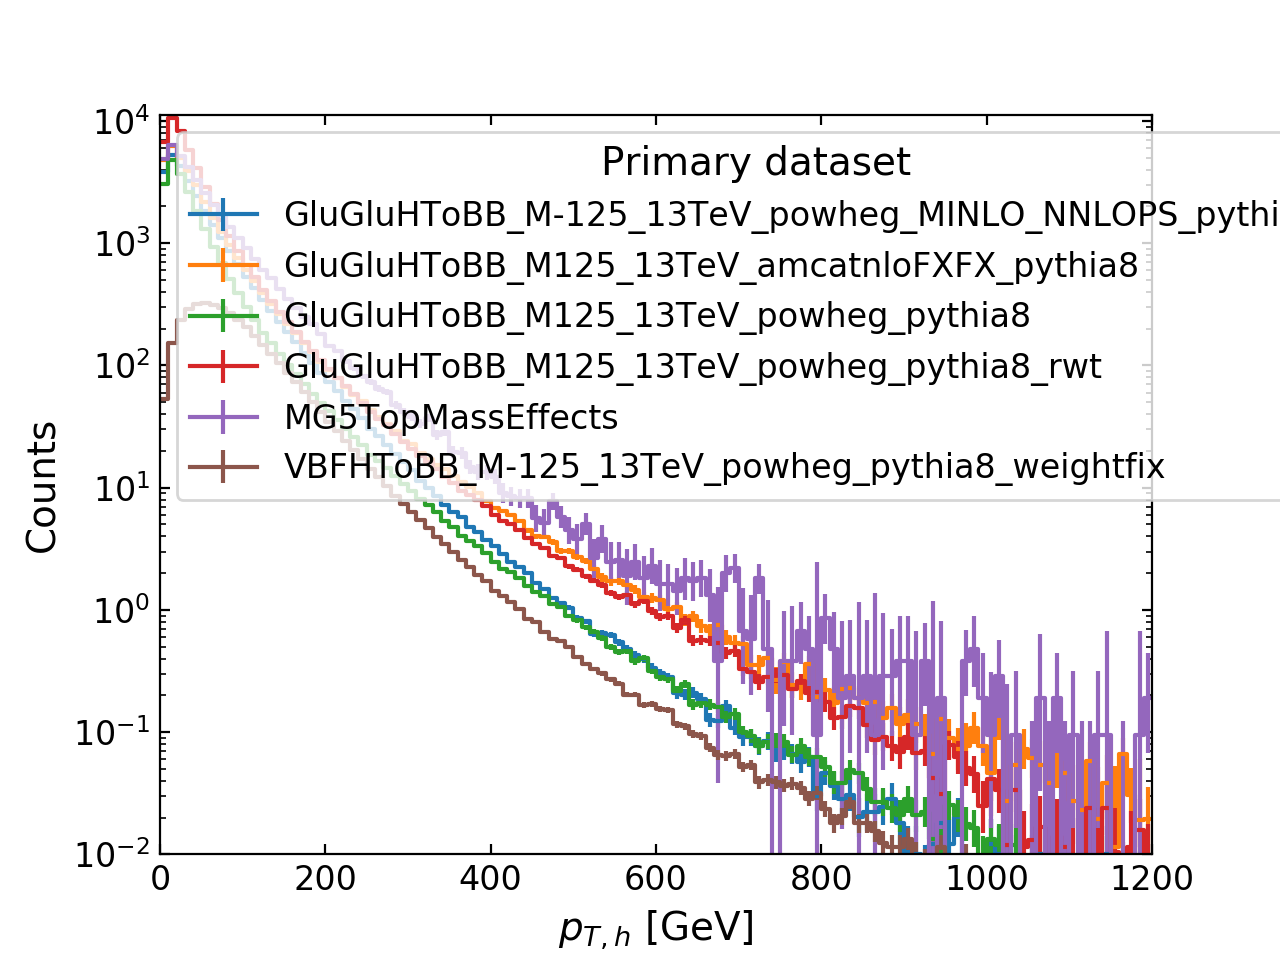

In [35]:
fig, ax, _ = plot.plot1d(outs['hpt_showered'].project('widx', 4), overlay='dataset')
#ax.set_xlim(250, None)
ax.set_ylim(.01, None)
ax.set_yscale('log')

In [43]:
hpt = outs['hpt']

edges = hpt.axis('pt').edges()
values = {k[0]: v for k,v in hpt.values(sumw2=True, overflow='over').items()}
for k in values:
    sumw = np.cumsum(values[k][0][::-1], axis=0)[::-1]
    sumw2 = np.cumsum(values[k][1][::-1], axis=0)[::-1]
    nom = sumw[:,4]
    statw = np.sqrt(sumw2)[:,4]
    valid = [0, 1, 3, 4, 5, 7, 8]
    scaleup = np.max(sumw[:,valid], axis=1)
    scaledn = np.min(sumw[:,valid], axis=1)
    values[k] = (nom, statw, scaleup, scaledn)

In [44]:
# https://cds.cern.ch/record/2669113/files/LHCHXSWG-2019-002.pdf
# Table 8
edges_xswg = np.array([   400,   430,   450,  500,  550,  600,  650,  700,  750,  800])
values_xswg = np.array([32.03, 22.05, 17.37, 9.66, 5.54, 3.24, 1.94, 1.15, 0.69, 0.41])

from scipy.interpolate import interp1d
interp_xswg = interp1d(edges_xswg, values_xswg, kind='cubic')

<IPython.core.display.Javascript object>


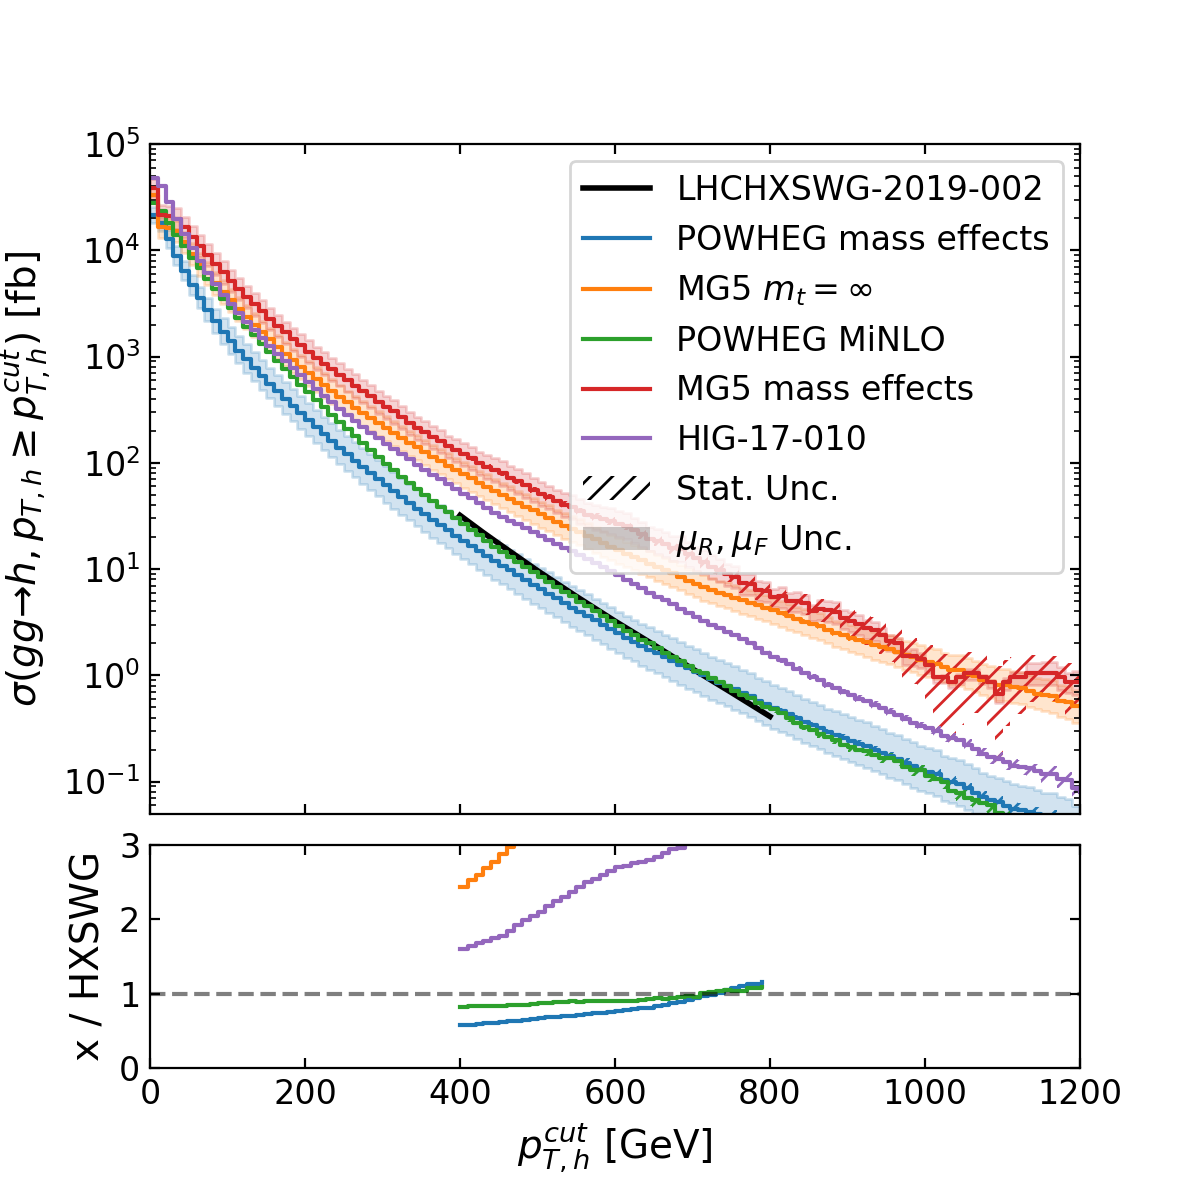

Text(0.5, 0, '$p_{T,h}^{cut}$ [GeV]')

In [45]:
fig, (ax, rax) = plt.subplots(2, 1, figsize=(6,6), gridspec_kw={"height_ratios": (3, 1)}, sharex=True)
fig.subplots_adjust(hspace=.07)

def draw(key, label, scale=True):
    nom, statw, scaleup, scaledn = values[key]
    line, = ax.step(x=edges, y=nom, where='post', label=label)
    fill = ax.fill_between(x=edges, y1=nom - statw, y2=nom + statw,
                           facecolor='none', edgecolor=line.get_color(), hatch='///', linewidth=0, step='post', label='_')
    if scale:
        fills = ax.fill_between(x=edges, y1=scaledn, y2=scaleup,
                           color=line.get_color(), alpha=0.2, step='post', label='_')
    
    cut = (edges >= edges_xswg[0]) & (edges < edges_xswg[-1])
    rline, = rax.step(edges[cut], nom[cut]/interp_xswg(edges[cut]), color=line.get_color(), where='post')
    return line

l0, = ax.plot(edges_xswg, values_xswg, linestyle='-', color='k', linewidth=2, label='LHCHXSWG-2019-002')


# http://home.fnal.gov/~ncsmith/gg_H_quark-mass-effects_NNPDF31_13TeV_M125_slc6_amd64_gcc630_CMSSW_9_3_0.powheg.input
# https://arxiv.org/pdf/1111.2854.pdf
l1 = draw('GluGluHToBB_M125_13TeV_powheg_pythia8', 'POWHEG mass effects')


#l2 = draw('GluGluHToBB_M125_LHEHpT_250-Inf_13TeV_amcatnloFXFX_pythia8', r'MG5 $m_{t}=\infty$')
l2 = draw('GluGluHToBB_M125_13TeV_amcatnloFXFX_pythia8', r'MG5 $m_{t}=\infty$')


# https://github.com/cms-sw/genproductions/blob/b8c44435bd90b2e11cdd21ba596113b1b278a38c/bin/Powheg/production/2017/13TeV/Higgs/HJ_MiNLO_NNLOPS_NNPDF31_13TeV/HJ_MiNLO_NNLOPS_NNPDF31_13TeV.input
# https://arxiv.org/pdf/1212.4504.pdf
l3 = draw('GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8', 'POWHEG MiNLO', scale=False)


l4 = draw('MG5TopMassEffects', 'MG5 mass effects')

l5 = draw('GluGluHToBB_M125_13TeV_powheg_pythia8_rwt', 'HIG-17-010', scale=False)

ax.set_yscale('log')
ax.set_ylim(5e-2, 1e5)
ax.set_ylabel(r'$\sigma(gg\to h, p_{T,h}\geq p_{T,h}^{cut})$ [fb]')

from matplotlib.patches import Patch
statpatch = Patch(facecolor='none', edgecolor='k', hatch='///', linewidth=0, label='Stat. Unc.')
scalepatch = Patch(facecolor='black', alpha=0.2, label=r'$\mu_R,\mu_F$ Unc.')
litems = [l0, l1, l2, l3, l4, l5, statpatch, scalepatch]
ax.legend(litems, [x.get_label() for x in litems])


rax.set_xlim(0, 1200)
rax.set_ylim(0, 3)
rax.axhline(1, alpha=0.5, color='k', linestyle='--')
rax.set_ylabel('x / HXSWG')
rax.set_xlabel(r'$p_{T,h}^{cut}$ [GeV]')

In [46]:
fig.savefig('hxswg_cmsgenerators_comparison.pdf')

<IPython.core.display.Javascript object>


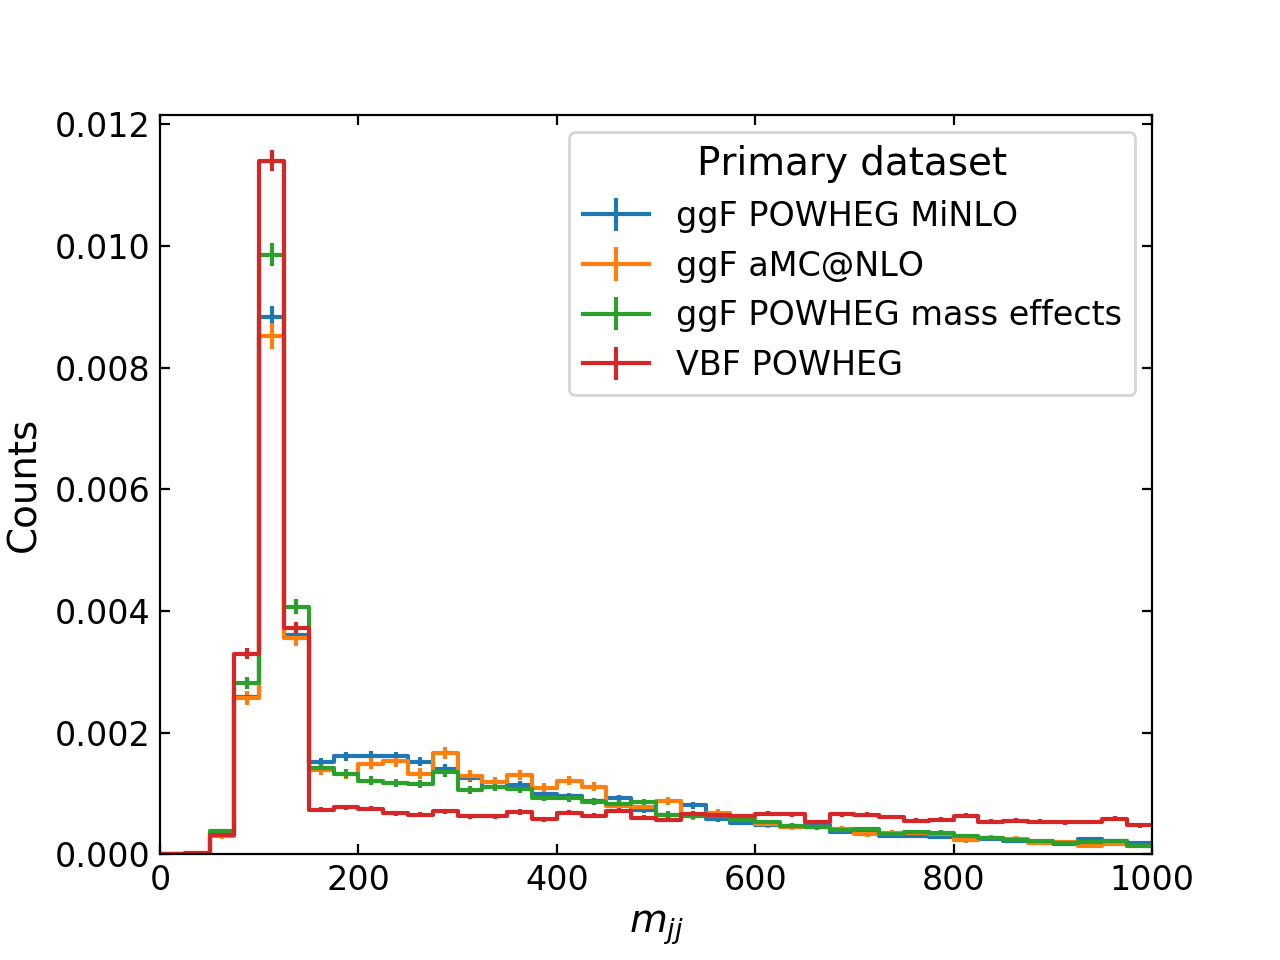

In [41]:
labels = {
    'GluGluHToBB_M125_13TeV_powheg_pythia8': 'ggF POWHEG mass effects',
    'GluGluHToBB_M125_13TeV_amcatnloFXFX_pythia8': 'ggF aMC@NLO',
    'GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8': 'ggF POWHEG MiNLO',
    'VBFHToBB_M-125_13TeV_powheg_pythia8_weightfix': 'VBF POWHEG',
    #'MG5TopMassEffects': 'MG5 mass effects',
}
h = outs['vbfvars'][list(labels.keys())]
for k, v in labels.items():
    h.axis('dataset').index(k).label = v
fig, ax, _ = plot.plot1d(h.sum('detajj').project('widx', 4), overlay='dataset', density=True)

In [58]:
fig.savefig('detajj_higgsComparison.pdf')

In [42]:
values_showered = values

<IPython.core.display.Javascript object>


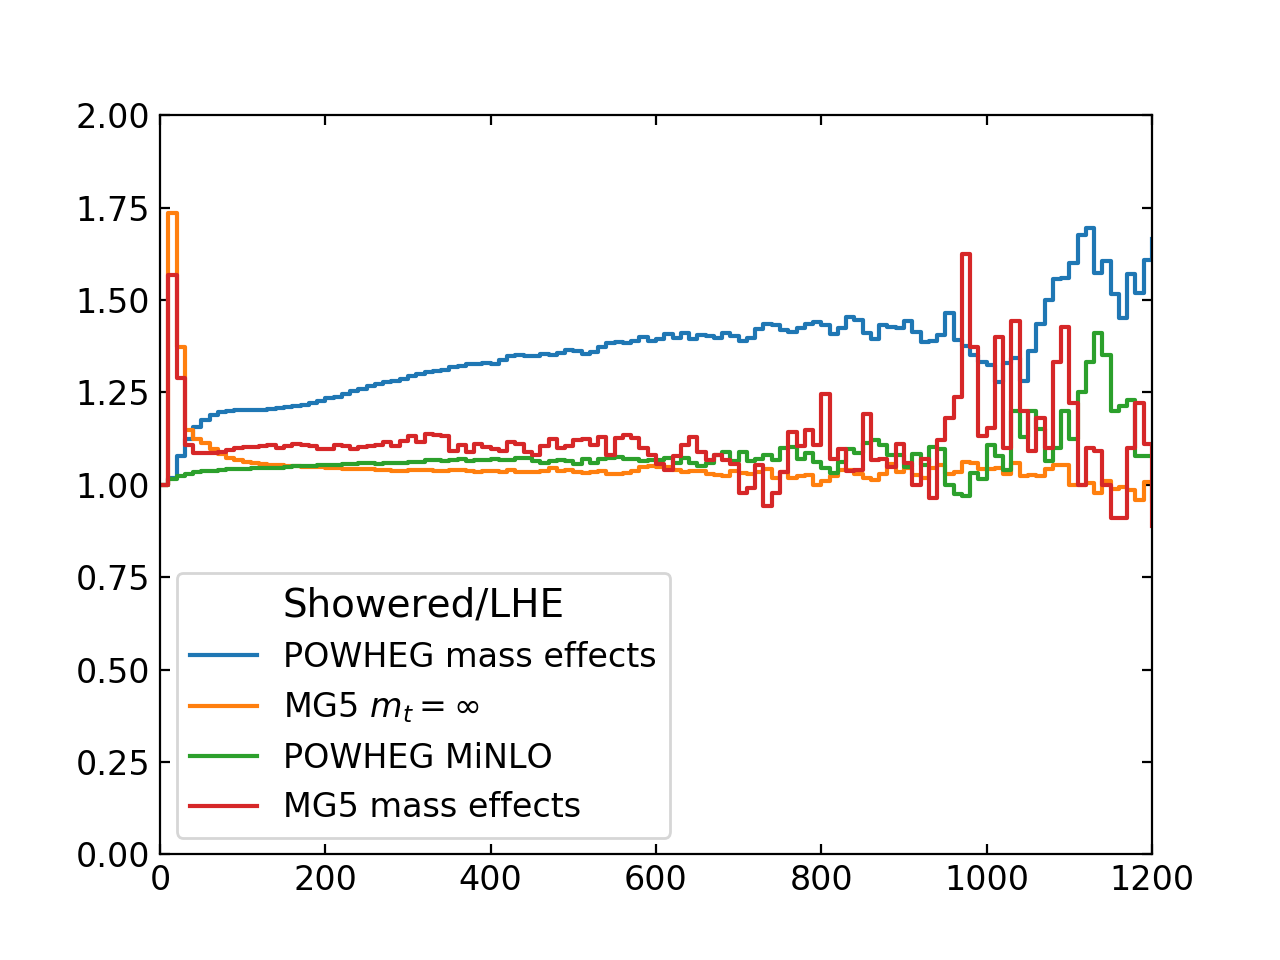

(0, 1200)

In [57]:
fig, ax = plt.subplots()

labels = {
    'GluGluHToBB_M125_13TeV_powheg_pythia8': 'POWHEG mass effects',
    'GluGluHToBB_M125_13TeV_amcatnloFXFX_pythia8': 'MG5 $m_{t}=\infty$',
    'GluGluHToBB_M-125_13TeV_powheg_MINLO_NNLOPS_pythia8': 'POWHEG MiNLO',
    'MG5TopMassEffects': 'MG5 mass effects',
}
for proc, lbl in labels.items():
    lhe = values[proc][0]
    showered = (values_showered[proc][0])
    ax.step(x=edges[:], y=showered/lhe, where='post', label=lbl)
ax.set_ylim(0, 2)
ax.legend(title='Showered/LHE')
ax.set_xlim(0, 1200)

In [56]:
fig.savefig('showered_vs_lhe.pdf')